# Task:

1. Working on the CPU with a reseaonable number of statistics try to plot the figure 9.
2. Increase the number of statistics for the validation $\leftarrow$
3. Try with one event and try to debug.
5. Produce the plots for the MET
6. For the statistics, plot for on event. 

1. Work on the jet part and build some understanding
`you have to use fastjet to create the jets yourself.
three times: once for genjets from genparticles, and then from reco particles for fp32 and int8 models.
like this: https://github.com/jpata/particleflow/blob/main/mlpf/pyg/inference.py#L74-L75
then you can match the two jet collections (see imports): https://github.com/jpata/particleflow/blob/main/mlpf/pyg/inference.py#L108`

4. Try to plot IQR/median vs P-gen for the JET




04/22/2024
* Try to show the individual response distributions in each bin also?
* Try to check and match the two jet collections. 
* Try with Increased statistics
* Update the slides.


In [1]:
import numpy as np
import pandas as pd
import time
import tqdm

import ROOT

import vector

Welcome to JupyROOT 6.30/02


In [2]:
import torch
from torch import nn, Tensor
import tensorflow_datasets as tfds
import torch_geometric
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
device = "cuda"

In [4]:
# Datasets
data_dir = "../../mlpf/tensorflow_datasets/"
dataset = "clic_edm_ttbar_pf"

# Load dataset
builder = tfds.builder(dataset, data_dir=data_dir)
ds_train = builder.as_data_source(split="train")

In [5]:
X_FEATURES_TRK = [
    "elemtype",
    "pt",
    "eta",
    "sin_phi",
    "cos_phi",
    "p",
    "chi2",
    "ndf",
    "dEdx",
    "dEdxError",
    "radiusOfInnermostHit",
    "tanLambda",
    "D0",
    "omega",
    "Z0",
    "time",
]
X_FEATURES_CL = [
    "elemtype",
    "et",
    "eta",
    "sin_phi",
    "cos_phi",
    "energy",
    "position.x",
    "position.y",
    "position.z",
    "iTheta",
    "energy_ecal",
    "energy_hcal",
    "energy_other",
    "num_hits",
    "sigma_x",
    "sigma_y",
    "sigma_z",
]
Y_FEATURES = ["cls_id", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]
Y_CLASSES = [0, 211, 130, 22, 11, 13]

INPUT_DIM = max(len(X_FEATURES_TRK), len(X_FEATURES_CL))
NUM_CLASSES = len(Y_CLASSES)

# Model

In [6]:
# JP 2024-02-29: currently torch int8 onnx export does not work with MultiheadAttention because of the following:
# - it uses q_scaling_product.mul_scalar which is not supported in ONNX opset 17: the fix is to just remove the q_scaling_product
# - somehow, the "need_weights" option confuses the ONNX exporter because the multiheaded attention layer then returns a tuple: the fix is to make the MHA always return just the attended values only
# I lifted these two modules directly from the pytorch code and made the modifications here.

import torch
from torch import nn
import torch.nn.functional as nnF

from torch import Tensor
from typing import Optional, Tuple

class QuantizeableMultiheadAttention(nn.MultiheadAttention):
    _FLOAT_MODULE = nn.MultiheadAttention

    r"""Quantizable implementation of the MultiheadAttention.

    Note::
        Please, refer to :class:`~torch.nn.MultiheadAttention` for more
        information

    Allows the model to jointly attend to information from different
    representation subspaces.
    See reference: Attention Is All You Need

    The original MHA module is not quantizable.
    This reimplements it by explicitly instantiating the linear layers.

    .. math::
        \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
        \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

    Args:
        embed_dim: total dimension of the model.
        num_heads: parallel attention heads.
        dropout: a Dropout layer on attn_output_weights. Default: 0.0.
        bias: add bias as module parameter. Default: True.
        add_bias_kv: add bias to the key and value sequences at dim=0.
        add_zero_attn: add a new batch of zeros to the key and
                       value sequences at dim=1.
        kdim: total number of features in key. Default: None.
        vdim: total number of features in value. Default: None.
        batch_first: If ``True``, then the input and output tensors are provided
            as (batch, seq, feature). Default: ``False`` (seq, batch, feature).

    Note that if :attr:`kdim` and :attr:`vdim` are None, they will be set
    to :attr:`embed_dim` such that query, key, and value have the same
    number of features.

    Examples::

        >>> import torch.ao.nn.quantizable as nnqa
        >>> multihead_attn = nnqa.MultiheadAttention(embed_dim, num_heads)
        >>> attn_output, attn_output_weights = multihead_attn(query, key, value)

    Note::
        Please, follow the quantization flow to convert the quantizable MHA.
    """
    __constants__ = ['batch_first']

    def __init__(self, embed_dim: int, num_heads: int,
                 dropout: float = 0., bias: bool = True,
                 add_bias_kv: bool = False, add_zero_attn: bool = False,
                 kdim: Optional[int] = None, vdim: Optional[int] = None, batch_first: bool = False,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__(embed_dim, num_heads, dropout,
                         bias, add_bias_kv,
                         add_zero_attn, kdim, vdim, batch_first,
                         **factory_kwargs)
        self.linear_Q = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_K = nn.Linear(self.kdim, self.embed_dim, bias=bias, **factory_kwargs)
        self.linear_V = nn.Linear(self.vdim, self.embed_dim, bias=bias, **factory_kwargs)
        # for the type: ignore, see https://github.com/pytorch/pytorch/issues/58969
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=bias, **factory_kwargs)  # type: ignore[assignment]

        # Functionals
        # self.q_scaling_product = torch.ao.nn.quantized.FloatFunctional()
        # note: importing torch.ao.nn.quantized at top creates a circular import

        # Quant/Dequant
        self.quant_attn_output = torch.ao.quantization.QuantStub()
        self.quant_attn_output_weights = torch.ao.quantization.QuantStub()
        self.dequant_q = torch.ao.quantization.DeQuantStub()
        self.dequant_k = torch.ao.quantization.DeQuantStub()
        self.dequant_v = torch.ao.quantization.DeQuantStub()

    def _get_name(self):
        return 'QuantizableMultiheadAttention'

    @classmethod
    def from_float(cls, other):
        assert type(other) == cls._FLOAT_MODULE
        assert hasattr(other, 'qconfig'), "The float module must have 'qconfig'"
        # Setting the dropout to 0.0!
        observed = cls(other.embed_dim, other.num_heads, other.dropout,
                       (other.in_proj_bias is not None),
                       (other.bias_k is not None),
                       other.add_zero_attn, other.kdim, other.vdim,
                       other.batch_first)
        observed.bias_k = other.bias_k
        observed.bias_v = other.bias_v
        observed.qconfig = other.qconfig

        # Set the linear weights
        # for the type: ignores, see https://github.com/pytorch/pytorch/issues/58969
        observed.out_proj.weight = other.out_proj.weight  # type: ignore[has-type]
        observed.out_proj.bias = other.out_proj.bias  # type: ignore[has-type]
        if other._qkv_same_embed_dim:
            # Use separate params
            bias = other.in_proj_bias
            _start = 0
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_Q.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_Q.bias = bias

            bias = other.in_proj_bias
            _start = _end
            _end = _start + other.embed_dim
            weight = other.in_proj_weight[_start:_end, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:_end], bias.requires_grad)
            observed.linear_K.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_K.bias = bias

            bias = other.in_proj_bias
            _start = _end
            weight = other.in_proj_weight[_start:, :]
            if bias is not None:
                bias = torch.nn.Parameter(bias[_start:], bias.requires_grad)
            observed.linear_V.weight = torch.nn.Parameter(weight,
                                                          weight.requires_grad)
            observed.linear_V.bias = bias
        else:
            observed.linear_Q.weight = nn.Parameter(other.q_proj_weight)
            observed.linear_K.weight = nn.Parameter(other.k_proj_weight)
            observed.linear_V.weight = nn.Parameter(other.v_proj_weight)
            if other.in_proj_bias is None:
                observed.linear_Q.bias = None  # type: ignore[assignment]
                observed.linear_K.bias = None  # type: ignore[assignment]
                observed.linear_V.bias = None  # type: ignore[assignment]
            else:
                observed.linear_Q.bias = nn.Parameter(other.in_proj_bias[0:other.embed_dim])
                observed.linear_K.bias = nn.Parameter(other.in_proj_bias[other.embed_dim:(other.embed_dim * 2)])
                observed.linear_V.bias = nn.Parameter(other.in_proj_bias[(other.embed_dim * 2):])
        observed.eval()
        # Explicit prepare
        observed = torch.ao.quantization.prepare(observed, inplace=True)
        return observed

    @torch.jit.unused
    def dequantize(self):
        r"""Utility to convert the quantized MHA back to float.

        The motivation for this is that it is not trivial to conver the weights
        from the format that is used in the quantized version back to the
        float.
        """
        fp = self._FLOAT_MODULE(self.embed_dim, self.num_heads, self.dropout,
                                (self.linear_Q._weight_bias()[1] is not None),
                                (self.bias_k is not None),
                                self.add_zero_attn, self.kdim, self.vdim, self.batch_first)
        assert fp._qkv_same_embed_dim == self._qkv_same_embed_dim
        if self.bias_k is not None:
            fp.bias_k = nn.Parameter(self.bias_k.dequantize())
        if self.bias_v is not None:
            fp.bias_v = nn.Parameter(self.bias_v.dequantize())

        # Set the linear weights
        # Note: Because the linear layers are quantized, mypy does not nkow how
        # to deal with them -- might need to ignore the typing checks.
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        w, b = self.out_proj._weight_bias()  # type: ignore[operator, has-type]
        fp.out_proj.weight = nn.Parameter(w.dequantize())
        if b is not None:
            fp.out_proj.bias = nn.Parameter(b)

        wQ, bQ = self.linear_Q._weight_bias()  # type: ignore[operator]
        wQ = wQ.dequantize()
        wK, bK = self.linear_K._weight_bias()  # type: ignore[operator]
        wK = wK.dequantize()
        wV, bV = self.linear_V._weight_bias()  # type: ignore[operator]
        wV = wV.dequantize()
        if fp._qkv_same_embed_dim:
            # Use separate params
            _start = 0
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wQ
            if fp.in_proj_bias is not None:
                assert all(bQ == 0)
                fp.in_proj_bias[_start:_end] = bQ

            _start = _end
            _end = _start + fp.embed_dim
            fp.in_proj_weight[_start:_end, :] = wK
            if fp.in_proj_bias is not None:
                assert all(bK == 0)
                fp.in_proj_bias[_start:_end] = bK

            _start = _end
            fp.in_proj_weight[_start:, :] = wV
            if fp.in_proj_bias is not None:
                assert all(bV == 0)
                fp.in_proj_bias[_start:] = bV
        else:
            fp.q_proj_weight = nn.Parameter(wQ)
            fp.k_proj_weight = nn.Parameter(wK)
            fp.v_proj_weight = nn.Parameter(wV)
            if fp.in_proj_bias is None:
                self.linear_Q.bias = None
                self.linear_K.bias = None
                self.linear_V.bias = None
            else:
                fp.in_proj_bias[0:fp.embed_dim] = bQ
                fp.in_proj_bias[fp.embed_dim:(fp.embed_dim * 2)] = bK
                fp.in_proj_bias[(fp.embed_dim * 2):] = bV

        return fp


    @classmethod
    def from_observed(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does float -> observed only
        # See nn.quantized.MultiheadAttention
        raise NotImplementedError("It looks like you are trying to prepare an "
                                  "MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    def forward(self,
                query: Tensor,
                key: Tensor,
                value: Tensor,
                key_padding_mask: Optional[Tensor] = None,
                need_weights: bool = True,
                attn_mask: Optional[Tensor] = None,
                average_attn_weights: bool = True,
                is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        r"""
    Note::
        Please, refer to :func:`~torch.nn.MultiheadAttention.forward` for more
        information

    Args:
        query, key, value: map a query and a set of key-value pairs to an output.
            See "Attention Is All You Need" for more details.
        key_padding_mask: if provided, specified padding elements in the key will
            be ignored by the attention. When given a binary mask and a value is True,
            the corresponding value on the attention layer will be ignored.
        need_weights: output attn_output_weights.
        attn_mask: 2D or 3D mask that prevents attention to certain positions. A 2D mask will be broadcasted for all
            the batches while a 3D mask allows to specify a different mask for the entries of each batch.

    Shape:
        - Inputs:
        - query: :math:`(L, N, E)` where L is the target sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - key: :math:`(S, N, E)`, where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - value: :math:`(S, N, E)` where S is the source sequence length, N is the batch size, E is
          the embedding dimension. :math:`(N, S, E)` if ``batch_first`` is ``True``.
        - key_padding_mask: :math:`(N, S)` where N is the batch size, S is the source sequence length.
          If a BoolTensor is provided, the positions with the
          value of ``True`` will be ignored while the position with the value of ``False`` will be unchanged.
        - attn_mask: 2D mask :math:`(L, S)` where L is the target sequence length, S is the source sequence length.
          3D mask :math:`(N*num_heads, L, S)` where N is the batch size, L is the target sequence length,
          S is the source sequence length. attn_mask ensure that position i is allowed to attend the unmasked
          positions. If a BoolTensor is provided, positions with ``True``
          is not allowed to attend while ``False`` values will be unchanged. If a FloatTensor
          is provided, it will be added to the attention weight.
        - is_causal: If specified, applies a causal mask as attention mask. Mutually exclusive with providing attn_mask.
          Default: ``False``.
        - average_attn_weights: If true, indicates that the returned ``attn_weights`` should be averaged across
          heads. Otherwise, ``attn_weights`` are provided separately per head. Note that this flag only has an
          effect when ``need_weights=True.``. Default: True (i.e. average weights across heads)

        - Outputs:
        - attn_output: :math:`(L, N, E)` where L is the target sequence length, N is the batch size,
          E is the embedding dimension. :math:`(N, L, E)` if ``batch_first`` is ``True``.
        - attn_output_weights: If ``average_attn_weights=True``, returns attention weights averaged
          across heads of shape :math:`(N, L, S)`, where N is the batch size, L is the target sequence length,
          S is the source sequence length. If ``average_attn_weights=False``, returns attention weights per
          head of shape :math:`(N, num_heads, L, S)`.
        """
        return self._forward_impl(query, key, value, key_padding_mask,
                                  need_weights, attn_mask, average_attn_weights,
                                  is_causal)

    def _forward_impl(self,
                      query: Tensor,
                      key: Tensor,
                      value: Tensor,
                      key_padding_mask: Optional[Tensor] = None,
                      need_weights: bool = True,
                      attn_mask: Optional[Tensor] = None,
                      average_attn_weights: bool = True,
                      is_causal: bool = False) -> Tuple[Tensor, Optional[Tensor]]:
        # This version will not deal with the static key/value pairs.
        # Keeping it here for future changes.
        #
        # TODO: This method has some duplicate lines with the
        # `torch.nn.functional.multi_head_attention`. Will need to refactor.
        static_k = None
        static_v = None

        if attn_mask is not None and is_causal:
            raise AssertionError("Only allow causal mask or attn_mask")

        if is_causal:
            raise AssertionError("causal mask not supported by AO MHA module")

        if self.batch_first:
            query, key, value = (x.transpose(0, 1) for x in (query, key, value))

        tgt_len, bsz, embed_dim_to_check = query.size()
        assert self.embed_dim == embed_dim_to_check
        # allow MHA to have different sizes for the feature dimension
        assert key.size(0) == value.size(0) and key.size(1) == value.size(1)

        head_dim = self.embed_dim // self.num_heads
        assert head_dim * self.num_heads == self.embed_dim, "embed_dim must be divisible by num_heads"
        scaling = float(head_dim) ** -0.5

        q = self.linear_Q(query)
        k = self.linear_K(key)
        v = self.linear_V(value)

        #JP fix here: disabled this
        # q = self.q_scaling_product.mul_scalar(q, scaling)

        if attn_mask is not None:
            if attn_mask.dtype == torch.uint8:
                warnings.warn("Byte tensor for attn_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
                attn_mask = attn_mask.to(torch.bool)
            assert attn_mask.is_floating_point() or attn_mask.dtype == torch.bool, \
                f'Only float and bool types are supported for attn_mask, not {attn_mask.dtype}'

            if attn_mask.dim() == 2:
                attn_mask = attn_mask.unsqueeze(0)
                if list(attn_mask.size()) != [1, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 2D attn_mask is not correct.')
            elif attn_mask.dim() == 3:
                if list(attn_mask.size()) != [bsz * self.num_heads, query.size(0), key.size(0)]:
                    raise RuntimeError('The size of the 3D attn_mask is not correct.')
            else:
                raise RuntimeError(f"attn_mask's dimension {attn_mask.dim()} is not supported")
            # attn_mask's dim is 3 now.

        # convert ByteTensor key_padding_mask to bool
        if key_padding_mask is not None and key_padding_mask.dtype == torch.uint8:
            warnings.warn("Byte tensor for key_padding_mask in nn.MultiheadAttention is deprecated. Use bool tensor instead.")
            key_padding_mask = key_padding_mask.to(torch.bool)
        if self.bias_k is not None and self.bias_v is not None:
            if static_k is None and static_v is None:

                # Explicitly assert that bias_k and bias_v are not None
                # in a way that TorchScript can understand.
                bias_k = self.bias_k
                assert bias_k is not None
                bias_v = self.bias_v
                assert bias_v is not None

                k = torch.cat([k, bias_k.repeat(1, bsz, 1)])
                v = torch.cat([v, bias_v.repeat(1, bsz, 1)])
                if attn_mask is not None:
                    attn_mask = nnF.pad(attn_mask, (0, 1))
                if key_padding_mask is not None:
                    key_padding_mask = nnF.pad(key_padding_mask, (0, 1))
            else:
                assert static_k is None, "bias cannot be added to static key."
                assert static_v is None, "bias cannot be added to static value."
        else:
            assert self.bias_k is None
            assert self.bias_v is None

        q = q.contiguous().view(tgt_len, bsz * self.num_heads, head_dim).transpose(0, 1)
        if k is not None:
            k = k.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)
        if v is not None:
            v = v.contiguous().view(-1, bsz * self.num_heads, head_dim).transpose(0, 1)

        if static_k is not None:
            assert static_k.size(0) == bsz * self.num_heads
            assert static_k.size(2) == head_dim
            k = static_k

        if static_v is not None:
            assert static_v.size(0) == bsz * self.num_heads
            assert static_v.size(2) == head_dim
            v = static_v

        src_len = k.size(1)

        if key_padding_mask is not None:
            assert key_padding_mask.size(0) == bsz
            assert key_padding_mask.size(1) == src_len

        if self.add_zero_attn:
            src_len += 1
            k_zeros = torch.zeros((k.size(0), 1) + k.size()[2:])
            if k.is_quantized:
                k_zeros = torch.quantize_per_tensor(k_zeros, k.q_scale(), k.q_zero_point(), k.dtype)
            k = torch.cat([k, k_zeros], dim=1)
            v_zeros = torch.zeros((v.size(0), 1) + k.size()[2:])
            if v.is_quantized:
                v_zeros = torch.quantize_per_tensor(v_zeros, v.q_scale(), v.q_zero_point(), v.dtype)
            v = torch.cat([v, v_zeros], dim=1)

            if attn_mask is not None:
                attn_mask = nnF.pad(attn_mask, (0, 1))
            if key_padding_mask is not None:
                key_padding_mask = nnF.pad(key_padding_mask, (0, 1))

        # Leaving the quantized zone here
        q = self.dequant_q(q)
        k = self.dequant_k(k)
        v = self.dequant_v(v)
        attn_output_weights = torch.bmm(q, k.transpose(1, 2))
        assert list(attn_output_weights.size()) == [bsz * self.num_heads, tgt_len, src_len]

        if attn_mask is not None:
            if attn_mask.dtype == torch.bool:
                attn_output_weights.masked_fill_(attn_mask, float('-inf'))
            else:
                attn_output_weights += attn_mask

        if key_padding_mask is not None:
            attn_output_weights = attn_output_weights.view(bsz, self.num_heads, tgt_len, src_len)
            attn_output_weights = attn_output_weights.masked_fill(
                key_padding_mask.unsqueeze(1).unsqueeze(2),
                float('-inf'),
            )
            attn_output_weights = attn_output_weights.view(bsz * self.num_heads, tgt_len, src_len)

        attn_output_weights = nnF.softmax(
            attn_output_weights, dim=-1)
        attn_output_weights = nnF.dropout(attn_output_weights, p=self.dropout, training=self.training)

        attn_output = torch.bmm(attn_output_weights, v)
        assert list(attn_output.size()) == [bsz * self.num_heads, tgt_len, head_dim]
        if self.batch_first:
            attn_output = attn_output.view(bsz, tgt_len, self.embed_dim)
        else:
            attn_output = attn_output.transpose(0, 1).contiguous().view(tgt_len, bsz, self.embed_dim)

        # Reentering the quantized zone
        attn_output = self.quant_attn_output(attn_output)
        # for the type: ignore[has-type], see https://github.com/pytorch/pytorch/issues/58969
        attn_output = self.out_proj(attn_output)  # type: ignore[has-type]

        #JP fix: removed need_weights part from here, return attn_output instead of tuple
        return attn_output

class QuantizedMultiheadAttention(QuantizeableMultiheadAttention):
    _FLOAT_MODULE = torch.ao.nn.quantizable.MultiheadAttention

    def _get_name(self):
        return "QuantizedMultiheadAttention"

    @classmethod
    def from_float(cls, other):
        # The whole flow is float -> observed -> quantized
        # This class does observed -> quantized only
        raise NotImplementedError("It looks like you are trying to convert a "
                                  "non-observed MHA module. Please, see "
                                  "the examples on quantizable MHAs.")

    @classmethod
    def from_observed(cls, other):
        converted = torch.ao.quantization.convert(other, mapping=None,
                                                  inplace=False,
                                                  remove_qconfig=True,
                                                  convert_custom_config_dict=None)
        converted.__class__ = cls
        # Remove the parameters for the bias_k and bias_v to quantize them
        # TODO: This is a potential source of accuracy drop.
        #       quantized cat takes the scale and zp of the first
        #       element, which might lose the precision in the bias_k
        #       and the bias_v (which are cat'ed with k/v being first).
        if converted.bias_k is not None:
            bias_k = converted._parameters.pop('bias_k')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,
                                                      reduce_range=False)
            bias_k = torch.quantize_per_tensor(bias_k, sc, zp, torch.quint8)
            setattr(converted, 'bias_k', bias_k)  # noqa: B010

        if converted.bias_v is not None:
            bias_v = converted._parameters.pop('bias_v')
            sc, zp = torch._choose_qparams_per_tensor(bias_k,  # type: ignore[possibly-undefined]
                                                      reduce_range=False)
            bias_v = torch.quantize_per_tensor(bias_v, sc, zp, torch.quint8)
            setattr(converted, 'bias_v', bias_v)  # noqa: B010

        del converted.in_proj_weight
        del converted.in_proj_bias

        return converted


In [7]:
class FocalLoss(nn.Module):
    """Focal Loss, as described in https://arxiv.org/abs/1708.02002.
    It is essentially an enhancement to cross entropy loss and is
    useful for classification tasks when there is a large class imbalance.
    x is expected to contain raw, unnormalized scores for each class.
    y is expected to contain class labels.
    Shape:
        - x: (batch_size, C) or (batch_size, C, d1, d2, ..., dK), K > 0.
        - y: (batch_size,) or (batch_size, d1, d2, ..., dK), K > 0.
    """

    def __init__(
        self, alpha = None, gamma = 0.0, reduction = "mean", ignore_index = -100
    ):
        """Constructor.
        Args:
            alpha (Tensor, optional): Weights for each class. Defaults to None.
            gamma (float, optional): A constant, as described in the paper.
                Defaults to 0.
            reduction (str, optional): 'mean', 'sum' or 'none'.
                Defaults to 'mean'.
            ignore_index (int, optional): class label to ignore.
                Defaults to -100.
        """
        if reduction not in ("mean", "sum", "none"):
            raise ValueError('Reduction must be one of: "mean", "sum", "none".')

        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

        self.nll_loss = nn.NLLLoss(weight=alpha, reduction="none")

    def __repr__(self):
        arg_keys = ["alpha", "gamma", "reduction"]
        arg_vals = [self.__dict__[k] for k in arg_keys]
        arg_strs = [f"{k}={v!r}" for k, v in zip(arg_keys, arg_vals)]
        arg_str = ", ".join(arg_strs)
        return f"{type(self).__name__}({arg_str})"

    def forward(self, x: Tensor, y: Tensor) -> Tensor:
        if x.ndim > 2:
            # (N, C, d1, d2, ..., dK) --> (N * d1 * ... * dK, C)
            c = x.shape[1]
            x = x.permute(0, *range(2, x.ndim), 1).reshape(-1, c)
            # (N, d1, d2, ..., dK) --> (N * d1 * ... * dK,)
            y = y.view(-1)

        # compute weighted cross entropy term: -alpha * log(pt)
        # (alpha is already part of self.nll_loss)
        log_p = F.log_softmax(x, dim=-1)
        ce = self.nll_loss(log_p, y)

        # get true class column from each row
        # this is slow due to indexing
        # all_rows = torch.arange(len(x))
        # log_pt = log_p[all_rows, y]
        log_pt = torch.gather(log_p, 1, y.unsqueeze(axis=-1)).squeeze(axis=-1)

        # compute focal term: (1 - pt)^gamma
        pt = log_pt.exp()
        focal_term = (1 - pt) ** self.gamma

        # the full loss: -alpha * ((1 - pt)^gamma) * log(pt)
        loss = focal_term * ce

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss
        
def mlpf_loss(y, ypred, mask):
    loss = {}
    loss_obj_id = FocalLoss(gamma=2.0, reduction="none")

    msk_true_particle = torch.unsqueeze((y["cls_id"] != 0).to(dtype=torch.float32), axis=-1)
    nelem = torch.sum(mask)
    npart = torch.sum(y["cls_id"] != 0)
    
    ypred["momentum"] = ypred["momentum"] * msk_true_particle
    y["momentum"] = y["momentum"] * msk_true_particle

    ypred["cls_id_onehot"] = ypred["cls_id_onehot"].permute((0, 2, 1))

    loss_classification = loss_obj_id(ypred["cls_id_onehot"], y["cls_id"]).reshape(y["cls_id"].shape)
    loss_regression = torch.nn.functional.huber_loss(ypred["momentum"], y["momentum"], reduction="none")
    
    # average over all elements that were not padded
    loss["Classification"] = loss_classification.sum() / npart
    
    mom_normalizer = y["momentum"][y["cls_id"] != 0].std(axis=0)
    reg_losses = loss_regression[y["cls_id"] != 0]
    # average over all true particles
    loss["Regression"] = (reg_losses / mom_normalizer).sum() / npart

    px = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 3:4] * msk_true_particle
    py = ypred["momentum"][..., 0:1] * ypred["momentum"][..., 2:3] * msk_true_particle
    pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

    px = y["momentum"][..., 0:1] * y["momentum"][..., 3:4] * msk_true_particle
    py = y["momentum"][..., 0:1] * y["momentum"][..., 2:3] * msk_true_particle
    true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)
    loss["MET"] = torch.nn.functional.huber_loss(pred_met, true_met).mean()

    loss["Total"] = loss["Classification"] + loss["Regression"]
    # loss["Total"] += 0.1*loss["MET"]
    return loss

### Model definition

In [8]:
class QuantizeFeaturesStub(torch.ao.quantization.QuantStub):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
        
class SelfAttentionLayer(nn.Module):
    def __init__(
        self,
        embedding_dim=128,
        num_heads=2,
        width=128,
        dropout_mha=0.1,
        dropout_ff=0.1,
        attention_type="efficient",
    ):
        super(SelfAttentionLayer, self).__init__()

        self.attention_type = attention_type
        self.act = nn.ReLU
        self.mha = torch.nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout_mha, batch_first=True)
        self.norm0 = torch.nn.LayerNorm(embedding_dim)
        self.norm1 = torch.nn.LayerNorm(embedding_dim)
        self.seq = torch.nn.Sequential(
            nn.Linear(embedding_dim, width), self.act(), nn.Linear(width, embedding_dim), self.act()
        )
        self.dropout = torch.nn.Dropout(dropout_ff)

        self.add0 = torch.ao.nn.quantized.FloatFunctional()
        self.add1 = torch.ao.nn.quantized.FloatFunctional()
        self.mul = torch.ao.nn.quantized.FloatFunctional()

    def forward(self, x, mask):
        mha_out = self.mha(x, x, x, need_weights=False)[0]
        x = self.add0.add(x, mha_out)
        x = self.norm0(x)
        x = self.add1.add(x, self.seq(x))
        x = self.norm1(x)
        x = self.dropout(x)
        # x = self.mul.mul(x, mask.unsqueeze(-1))
        return x

class RegressionOutput(nn.Module):
    def __init__(self, embed_dim, width, act, dropout):
        super(RegressionOutput, self).__init__()
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.nn = ffn(embed_dim, 1, width, act, dropout)

    def forward(self, elems, x, orig_value):
        nn_out = self.nn(x)
        nn_out = self.dequant(nn_out)
        return orig_value + nn_out

def ffn(input_dim, output_dim, width, act, dropout):
    return nn.Sequential(
        nn.Linear(input_dim, width),
        act(),
        torch.nn.LayerNorm(width),
        nn.Dropout(dropout),
        nn.Linear(width, output_dim),
    )

def transform_batch(Xbatch):
    Xbatch = Xbatch.clone()
    Xbatch[..., 1] = torch.log(Xbatch[..., 1])
    Xbatch[..., 5] = torch.log(Xbatch[..., 5])
    Xbatch[torch.isnan(Xbatch)] = 0.0
    Xbatch[torch.isinf(Xbatch)] = 0.0
    return Xbatch
    
def unpack_target(y):
    ret = {}
    ret["cls_id"] = y[..., 0].long()

    for i, feat in enumerate(Y_FEATURES):
        if i >= 2:  # skip the cls and charge as they are defined above
            ret[feat] = y[..., i].to(dtype=torch.float32)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    
    # note ~ momentum = ["pt", "eta", "sin_phi", "cos_phi", "energy"]
    ret["momentum"] = y[..., 2:7].to(dtype=torch.float32)
    ret["p4"] = torch.cat(
        [ret["pt"].unsqueeze(1), ret["eta"].unsqueeze(1), ret["phi"].unsqueeze(1), ret["energy"].unsqueeze(1)], axis=1
    )

    return ret


def unpack_predictions(preds):
    ret = {}
    ret["cls_id_onehot"], ret["momentum"] = preds

    ret["pt"] = ret["momentum"][..., 0]
    ret["eta"] = ret["momentum"][..., 1]
    ret["sin_phi"] = ret["momentum"][..., 2]
    ret["cos_phi"] = ret["momentum"][..., 3]
    ret["energy"] = ret["momentum"][..., 4]

    ret["cls_id"] = torch.argmax(ret["cls_id_onehot"], axis=-1)
    ret["phi"] = torch.atan2(ret["sin_phi"], ret["cos_phi"])
    ret["p4"] = torch.cat(
        [
            ret["pt"].unsqueeze(axis=-1),
            ret["eta"].unsqueeze(axis=-1),
            ret["phi"].unsqueeze(axis=-1),
            ret["energy"].unsqueeze(axis=-1),
        ],
        axis=-1,
    )

    return ret

class MLPF(nn.Module):
    def __init__(
        self,
        input_dim=16,
        num_classes=6,
        num_convs=2,
        dropout_ff=0.0,
        dropout_conv_reg_mha=0.0,
        dropout_conv_reg_ff=0.0,
        dropout_conv_id_mha=0.0,
        dropout_conv_id_ff=0.0,
        num_heads=16,
        head_dim=16,
        elemtypes=[0,1,2],
    ):
        super(MLPF, self).__init__()
        self.input_dim = input_dim
        self.act = nn.ReLU
        self.elemtypes = elemtypes
        self.num_elemtypes = len(self.elemtypes)

        embedding_dim = num_heads * head_dim
        width = num_heads * head_dim
        
        self.nn0_id = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        self.nn0_reg = ffn(self.input_dim, embedding_dim, width, self.act, dropout_ff)
        
        self.conv_id = nn.ModuleList()
        self.conv_reg = nn.ModuleList()

        for i in range(num_convs):
            self.conv_id.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_id_mha,
                    dropout_ff=dropout_conv_id_ff,
                )
            )
            self.conv_reg.append(
                SelfAttentionLayer(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    width=width,
                    dropout_mha=dropout_conv_reg_mha,
                    dropout_ff=dropout_conv_reg_ff,
                )
            )

        decoding_dim = self.input_dim + embedding_dim

        # DNN that acts on the node level to predict the PID
        self.nn_id = ffn(decoding_dim, num_classes, width, self.act, dropout_ff)

        # elementwise DNN for node momentum regression
        embed_dim = decoding_dim + num_classes
        self.nn_pt = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_eta = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_sin_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_cos_phi = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        self.nn_energy = RegressionOutput(embed_dim, width, self.act, dropout_ff)
        
        self.quant = QuantizeFeaturesStub(self.input_dim + len(self.elemtypes))
        self.dequant_id = torch.ao.quantization.DeQuantStub()

    def forward(self, X_features, mask):
        Xfeat_transformed = transform_batch(X_features)
        Xfeat_normed = self.quant(Xfeat_transformed)

        embeddings_id, embeddings_reg = [], []
        embedding_id = self.nn0_id(Xfeat_normed)
        embedding_reg = self.nn0_reg(Xfeat_normed)
        for num, conv in enumerate(self.conv_id):
            conv_input = embedding_id if num == 0 else embeddings_id[-1]
            out_padded = conv(conv_input, mask)
            embeddings_id.append(out_padded)
        for num, conv in enumerate(self.conv_reg):
            conv_input = embedding_reg if num == 0 else embeddings_reg[-1]
            out_padded = conv(conv_input, mask)
            embeddings_reg.append(out_padded)

        final_embedding_id = torch.cat([Xfeat_normed] + [embeddings_id[-1]], axis=-1)
        preds_id = self.nn_id(final_embedding_id)

        final_embedding_reg = torch.cat([Xfeat_normed] + [embeddings_reg[-1]] + [preds_id], axis=-1)
        preds_pt = self.nn_pt(X_features, final_embedding_reg, X_features[..., 1:2])
        preds_eta = self.nn_eta(X_features, final_embedding_reg, X_features[..., 2:3])
        preds_sin_phi = self.nn_sin_phi(X_features, final_embedding_reg, X_features[..., 3:4])
        preds_cos_phi = self.nn_cos_phi(X_features, final_embedding_reg, X_features[..., 4:5])
        preds_energy = self.nn_energy(X_features, final_embedding_reg, X_features[..., 5:6])
        preds_momentum = torch.cat([preds_pt, preds_eta, preds_sin_phi, preds_cos_phi, preds_energy], axis=-1)
        
        preds_id = self.dequant_id(preds_id)
        return preds_id, preds_momentum

# Training 

In [9]:
max_events_train = 10000
max_events_eval = 10000
events_per_batch = 50
nepochs = 10

model = MLPF(input_dim=INPUT_DIM, num_classes=NUM_CLASSES).to(device=device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

#Training loop
loss_vals_epochs = []
for epoch in range(nepochs):
    loss_vals_steps = []
    inds_train = range(0,max_events_train,events_per_batch)
    for ind in tqdm.tqdm(inds_train):
        optimizer.zero_grad()

        #load the data for one batch
        ds_elems = [ds_train[i] for i in range(ind,ind+events_per_batch)]
        X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
        y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]

        #batch the data into [batch_size, num_elems, num_features]
        X_features_padded = pad_sequence(X_features, batch_first=True).to(device=device)
        y_targets_padded = pad_sequence(y_targets, batch_first=True).to(device=device)
        mask = X_features_padded[:, :, 0]!=0

        #run the model
        preds = model(X_features_padded, mask)
        preds_unpacked = unpack_predictions(preds)
        targets_unpacked = unpack_target(y_targets_padded)

        #compute loss, update model weights
        loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)
        loss["Total"].backward()
        optimizer.step()
        
        loss_vals_steps.append(loss["Total"].detach().cpu().item())

    loss_vals_epochs.append(np.mean(loss_vals_steps))
    print("Epoch {}, loss={:.2f}".format(epoch, loss_vals_epochs[-1]))

100%|█████████████████████████████████████████| 200/200 [00:49<00:00,  4.05it/s]


Epoch 0, loss=1.14


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.98it/s]


Epoch 1, loss=0.73


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.96it/s]


Epoch 2, loss=0.67


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.95it/s]


Epoch 3, loss=0.64


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.94it/s]


Epoch 4, loss=0.62


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.94it/s]


Epoch 5, loss=0.61


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.95it/s]


Epoch 6, loss=0.60


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.93it/s]


Epoch 7, loss=0.59


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.92it/s]


Epoch 8, loss=0.59


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.90it/s]


Epoch 9, loss=0.58


In [11]:
# plt.plot(loss_vals_epochs, label="training loss")

# Evaluation


In [12]:
# #put the model back on CPU
# model = model.to(device="cpu")

# #get the validation data
# ds_elems = [ds_train[i] for i in range(max_events_train,max_events_train+max_events_eval)]
# X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in ds_elems]
# X_features_padded = pad_sequence(X_features, batch_first=True)
# y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in ds_elems]
# y_targets_padded = pad_sequence(y_targets, batch_first=True)
# mask = X_features_padded[:, :, 0]!=0

In [ ]:
# preds = model(X_features_padded, mask)
# preds = preds[0].detach(), preds[1].detach()
# mask = X_features_padded[:, :, 0:1] != 0
# preds_unpacked = unpack_predictions(preds)
# targets_unpacked = unpack_target(y_targets_padded)

# loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

In [124]:
#put the model back on CPU
model = model.to(device="cpu")

all_preds = []
all_targets = []

ds_elems = [ds_train[i] for i in range(max_events_train, max_events_train + max_events_eval)]

# Define batch size
batch_size = 32  
for i in range(0, len(ds_elems), batch_size):
    batch_elems = ds_elems[i:i + batch_size]
    # input features
    X_features = [torch.tensor(elem["X"]).to(torch.float32) for elem in batch_elems]
    X_features_padded = pad_sequence(X_features, batch_first=True)
    #  target labels
    y_targets = [torch.tensor(elem["ygen"]).to(torch.float32) for elem in batch_elems]
    y_targets_padded = pad_sequence(y_targets, batch_first=True)
    #  mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    #  model prediction, loss computation
    preds = model(X_features_padded, mask)
    preds = preds[0].detach(), preds[1].detach()
    # Update mask for the batch
    mask = X_features_padded[:, :, 0] != 0
    # Unpack predictions and targets for the batch
    preds_unpacked = unpack_predictions(preds)
    targets_unpacked = unpack_target(y_targets_padded)
    # append to a list 
    all_preds.append(preds_unpacked)
    all_targets.append(targets_unpacked)
    # Compute loss for the batch
    loss = mlpf_loss(targets_unpacked, preds_unpacked, mask)

In [125]:
print(preds_unpacked)

{'cls_id_onehot': tensor([[[ 0.3563,  1.1781,  0.3953,  ...,  6.4013,  6.4013,  6.4013],
         [ 3.5805,  4.7654,  4.8608,  ..., -1.8970, -1.8970, -1.8970],
         [-3.8403, -3.9522, -3.8658,  ..., -0.7016, -0.7016, -0.7016],
         [-5.0588, -5.4636, -5.5030,  ...,  0.7592,  0.7592,  0.7592],
         [ 3.0775,  2.9264,  2.9702,  ..., -1.5827, -1.5827, -1.5827],
         [ 3.1223,  2.6607,  3.1947,  ..., -3.5974, -3.5974, -3.5974]],

        [[-0.4467, -0.4433, -0.0190,  ...,  6.4109,  6.4109,  6.4109],
         [ 3.6143,  3.8421,  4.9104,  ..., -2.1722, -2.1722, -2.1722],
         [-3.9048, -4.0548, -3.8570,  ..., -0.4733, -0.4733, -0.4733],
         [-4.9752, -4.2885, -5.3973,  ...,  0.6762,  0.6762,  0.6762],
         [ 3.4066,  2.5665,  3.0056,  ..., -1.5339, -1.5339, -1.5339],
         [ 3.5990,  3.2428,  3.3394,  ..., -3.4729, -3.4729, -3.4729]],

        [[-1.0022,  1.9756, -0.2400,  ...,  6.4189,  6.4189,  6.4189],
         [ 3.5675,  3.9539,  4.5812,  ..., -2.2087, -2.

In [126]:
msk_true_particles = targets_unpacked["cls_id"]!=0
msk_pred_particles = preds_unpacked["cls_id"]!=0


pt_target = targets_unpacked["pt"][msk_true_particles].numpy()
pt_pred = preds_unpacked["pt"][msk_true_particles].numpy()

eta_target = targets_unpacked["eta"][msk_true_particles].numpy()
eta_pred = preds_unpacked["eta"][msk_true_particles].numpy()

sphi_target = targets_unpacked["sin_phi"][msk_true_particles].numpy()
sphi_pred = preds_unpacked["sin_phi"][msk_true_particles].numpy()

cphi_target = targets_unpacked["cos_phi"][msk_true_particles].numpy()
cphi_pred = preds_unpacked["cos_phi"][msk_true_particles].numpy()

energy_target = targets_unpacked["energy"][msk_true_particles].numpy()
energy_pred = preds_unpacked["energy"][msk_true_particles].numpy()

px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_true_particles
py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_true_particles
pred_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
true_met = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

Is this right?

true_met is PF while the pred_met is the MLPF

targets_unpacked is the yvlas for the gen particle 

In [127]:
px = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
# phi = np.arctan2(targets_unpacked["sin_phi"], targets_unpacked["cos_phi"]) * msk_true_particles

px_np = px.detach().cpu().numpy()
py_np = py.detach().cpu().numpy()
pz_np = pz.detach().cpu().numpy()
# phi_np = phi.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

true_mom = np.sqrt(np.sum(px_np, axis=1)**2 + np.sum(py_np, axis=1)**2 + np.sum(pz_np, axis=1)**2)

E = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


In [128]:
# px

In [129]:
# px.shape

In [130]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E.shape)
print("px Shape", px.shape)
print("py Shape", py.shape)
print("pz Shape", pz.shape)

E Shape (16, 200)
px Shape torch.Size([16, 200])
py Shape torch.Size([16, 200])
pz Shape torch.Size([16, 200])


## Jets

* Use fastjet to create the jets 
* Create jets three times: 
        * Once for genjets from the genparticle
        * Then from Reco Particles for FP32
        * Then from Reco particles for Int8
like this https://github.com/jpata/particleflow/blob/main/mlpf/pyg/inference.py#L74-L75
then you can match the two jet collections(see imports):
https://github.com/jpata/particleflow/blob/main/mlpf/pyg/inference.py#L108


Here, \
**generated particles** = 'y_targets' targets_unpacked \
**Reconstucted particles** = 'preds_unpacked'

In [131]:
import fastjet as fj
import numpy as np
import awkward

# Four momentum 
px_np = targets_unpacked["pt"] * targets_unpacked["cos_phi"] * msk_true_particles
py_np = targets_unpacked["pt"] * targets_unpacked["sin_phi"] * msk_true_particles
pz_np = targets_unpacked["pt"] * np.sinh(targets_unpacked["eta"]) * msk_true_particles
E_np = np.sqrt(px_np**2 + py_np**2 + pz_np**2)


particles = []
for ip in range(E.shape[0]):
    for ix in range(E.shape[1]):
        px_value = float(px[ip, ix])
        py_value = float(py[ip, ix])
        pz_value = float(pz[ip, ix])
        E_value = float(E[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        particles.append(particle)

# print(particles)

In [132]:
# # jets clustering
# jetdef = fj.JetDefinition(fj.kt_algorithm, 0.4)  # jet def
# jet_ptcut = 20  # minimum jet pT
# cluster = fj.ClusterSequence(particles, jetdef)
# gen_jets = cluster.inclusive_jets(jet_ptcut)


In [133]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.antikt_algorithm, 0.4)
    jet_ptcut = 20
    
    cluster = fj.ClusterSequence(particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

gen_jets = []
for future in futures:
    gen_jets.extend(future.result())


In [134]:
for i, jet in enumerate(gen_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 0.0 100000.0 0.0 0.0
Jet 2 : 0.09008180599994484 1.688399518593333 3.2425325581975115 0.25203219056129456
Jet 3 : 0.17982952874409136 -1.941609349323064 4.889030393616061 0.639602541923523
Jet 4 : 0.2837854760326249 -1.8141478483815194 0.4866857889220741 0.8944984823465347
Jet 5 : 0.2859382609952973 -1.9548903712942536 3.645599694978839 1.0300532579421997
Jet 6 : 0.2861308201805592 1.4929310143035923 5.637340268478351 0.6694888025522232
Jet 7 : 0.2941379938467729 -0.5734575981788513 5.126227084403801 0.34384217858314514
Jet 8 : 0.34877210409722875 2.7549483849198912 5.248549077315376 2.7524819374084473
Jet 9 : 0.7310028699480715 1.6662947650453737 1.0580164066776132 2.007584549486637
Jet 10 : 0.4586502391642163 -2.3523484180470198 3.432486624089657 2.432077407836914
Jet 11 : 0.5854769714691771 1.2410637209194975 6.108714461801074 1.0999619364738464
Jet 12 : 0.5117624579438147 1.7349982561534527 0.0651537824822924 1.4957072734832764
Jet 13 : 0.6431122777985504 -2.052262868542354

Jet 146 : 19.53101068706806 -1.5660368155402598 2.707440046876794 48.901311814785004
Jet 147 : 17.51795135232313 -1.0481533835760861 0.12875016239488013 28.119235634803772
Jet 148 : 32.383368064595764 -0.7752423711986168 1.6511487714128257 42.99904191493988
Jet 149 : 24.575444916321096 0.7071393767516251 1.6533468221288372 31.20842182636261
Jet 150 : 26.38813572291076 -0.3105969389891216 5.581028413232692 27.92176215350628
Jet 151 : 28.32288525186962 0.326942078444031 5.947270418878389 29.98228567838669
Jet 152 : 28.426722840792202 -0.9030113154964198 5.746342646790488 40.95490036904812
Jet 153 : 33.06331020012623 -0.5502452223533817 3.4690151883315714 38.668117083609104
Jet 154 : 35.31674577806343 1.2831075573139208 2.7030080187987897 69.01223266124725
Jet 155 : 46.77802953993305 -0.37010510629416293 4.2871245039676005 50.98260487988591
Jet 156 : 37.778117131995344 -0.6776013128814913 2.877211296594381 47.01843413710594
Jet 157 : 42.95086020458949 -0.8508255710673986 4.831842017212927

In [135]:
print("Number of Jets:", len(gen_jets))


gen_jet_pt = [jet.pt() for jet in gen_jets]

Number of Jets: 171


In [136]:
import ROOT
import numpy as np

bins = [10, 20, 30, 40, 60, 80, 100, 200]


In [137]:
import ROOT
import numpy as np

#  bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

#  lists to store values
x_vals = []
ratio_iqr_median = []

# Iterating over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filtering out jet pT values within each bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]
    print("Jet pT values in bin {}: {}".format(i+1, jet_values_in_bin))  # Debugging

Jet pT values in bin 1: [12.649320604506695, 14.15847641367517, 14.387673980517874, 16.86288835543882, 15.381316676084879, 17.15332006249997, 10.8222110574853, 10.199366240725151, 12.570130396759065, 13.360775114966016, 14.48123236311218, 15.031209510997954, 16.27194893325761, 17.599453253789186, 19.53101068706806, 17.51795135232313]
Jet pT values in bin 2: [20.330874062264495, 24.319082095283687, 24.575444916321096, 26.38813572291076, 28.32288525186962, 28.426722840792202]
Jet pT values in bin 3: [33.45376450642645, 32.95423287496457, 37.7519534974596, 32.383368064595764, 33.06331020012623, 35.31674577806343, 37.778117131995344]
Jet pT values in bin 4: [42.367516874189036, 43.30461856407952, 41.06055862124583, 57.53015410728962, 52.46621772514502, 46.77802953993305, 42.95086020458949, 46.906766803557694, 52.79806624499606, 49.165278111072624, 50.17757669133995, 54.078867873360856, 58.079518708466765]
Jet pT values in bin 5: [66.88772425633839, 69.29664754741536, 72.77305557586824, 65.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


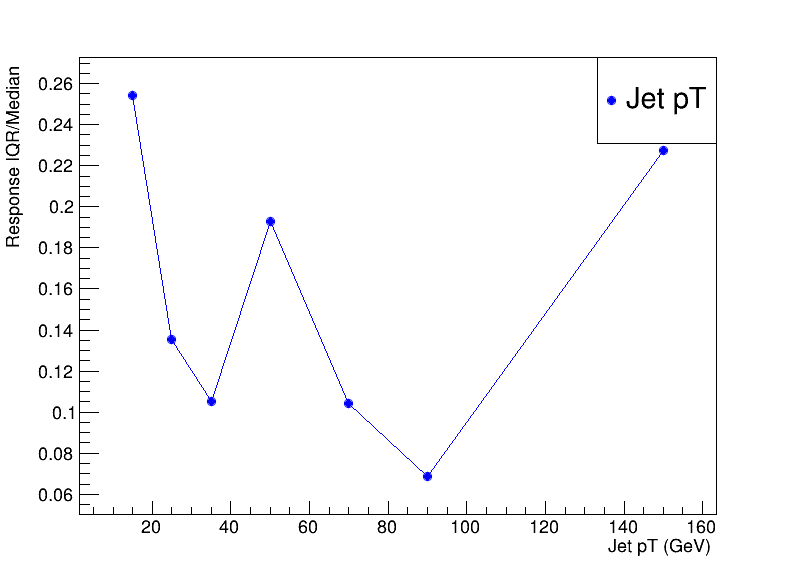

In [138]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter jet pT values within the bin
    jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any jet pT values in the bin
    if len(jet_values_in_bin) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue  # Skip calculation for this bin

    #  IQR and median for the jet pT values
    jet_iqr = np.percentile(jet_values_in_bin, 75) - np.percentile(jet_values_in_bin, 25)
    jet_median = np.median(jet_values_in_bin)
    ratio_iqr_median_ratio = jet_iqr / jet_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

#  We need to filter out NaN values,ROOT unable to print it
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))
# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet pT (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Jet pT", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


In [139]:
ratio_iqr_median

[0.2543052730682299,
 0.13562724697669346,
 0.10538658809351198,
 0.19309252475841274,
 0.10419922737446956,
 0.06859158337799913,
 0.2272403500309068]

In [140]:
## For reconstructed particles

In [141]:
reco_px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_pred_particles
reco_py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_pred_particles
reco_pz = preds_unpacked["pt"] * np.sinh(preds_unpacked["eta"]) * msk_pred_particles
reco_phi = np.arctan2(preds_unpacked["sin_phi"], preds_unpacked["cos_phi"]) * msk_pred_particles

reco_px_np = reco_px.detach().cpu().numpy()
reco_py_np = reco_py.detach().cpu().numpy()
reco_pz_np = reco_pz.detach().cpu().numpy()
reco_phi_np = reco_phi.detach().cpu().numpy()

# print("reco_px_np", reco_px_np)
# print("reco_py_np", reco_py_np)
# print("reco_pz_np", reco_pz_np)
# print("reco_phi_np", reco_phi_np)

reco_pred_mom = np.sqrt(np.sum(reco_px_np, axis=1)**2 + np.sum(reco_py_np, axis=1)**2 + np.sum(reco_pz_np, axis=1)**2)

reco_E_np = np.sqrt(reco_px_np**2 + reco_py_np**2 + reco_pz_np**2)


In [142]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E_np.shape)
print("px Shape", reco_px_np.shape)
print("py Shape", reco_py_np.shape)
print("pz Shape", reco_pz_np.shape)


E Shape torch.Size([16, 200])
px Shape (16, 200)
py Shape (16, 200)
pz Shape (16, 200)


In [143]:

reco_particles = []   # TODO:Change this to reco_jets
for ip in range(E_np.shape[0]):
    for ix in range(E_np.shape[1]):
        px_value = float(reco_px_np[ip, ix])
        py_value = float(reco_py_np[ip, ix])
        pz_value = float(reco_pz_np[ip, ix])
        E_value = float(E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        reco_particles.append(particle)


In [144]:
reco_particles

[<fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a8227900> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a82279c0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a82271b0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82daf60> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82da720> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82da690> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82da1e0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82dab40> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2c82dac30> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at

In [98]:
# # jets clustering
# jetdef = fj.JetDefinition(fj.kt_algorithm, 0.4)  # Define jet definition
# jet_ptcut = 20  # Minimum jet pT
# cluster = fj.ClusterSequence(reco_particles, jetdef)
# reco_jets = cluster.inclusive_jets(jet_ptcut)


In [145]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

# Function to perform jet clustering
def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.kt_algorithm, 0.4)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(reco_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

# Spliting particles list into chunks to process in parallel
chunks = [particles[i::num_threads] for i in range(num_threads)]

# jet clustering in parallel
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

reco_jets = []
for future in futures:
    reco_jets.extend(future.result())


In [146]:
for i, jet in enumerate(reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 282.7309550205681 -0.07981126562244142 2.5253859526547404 255.8260386735201
Jet 2 : 232.63831197311478 0.22624452551132937 4.358497148791175 217.3611255288124
Jet 3 : 221.5202327466023 0.3266468640001434 0.937440238596735 234.62524223327637
Jet 4 : 202.11162720081575 -0.6318942376105228 1.631372848403704 253.9236136674881
Jet 5 : 192.51027196343549 0.48746384931343484 6.267741459500561 216.50753338634968
Jet 6 : 171.21384897293953 -0.39665245891007767 4.08217682532686 132.1868110895157
Jet 7 : 167.6636540236138 0.7146471939594247 5.563964414438456 223.21614190936089
Jet 8 : 167.57342643604028 -0.13514896983942828 1.6117122987949146 163.02791891992092
Jet 9 : 165.9078920802334 -0.5071436278905891 4.760841492119673 205.4177352488041
Jet 10 : 146.08769087193423 0.886530026790469 1.1735785685905338 207.95896912366152
Jet 11 : 145.71554340571157 -0.6932198580572448 3.609665651625705 180.90213072299957
Jet 12 : 126.73693809017773 0.4342645131439902 0.41375490823554145 136.65614642202

In [147]:
print("Number of Jets:", len(reco_jets))


reco_jet_pt = [jet.pt() for jet in reco_jets]

Number of Jets: 158


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


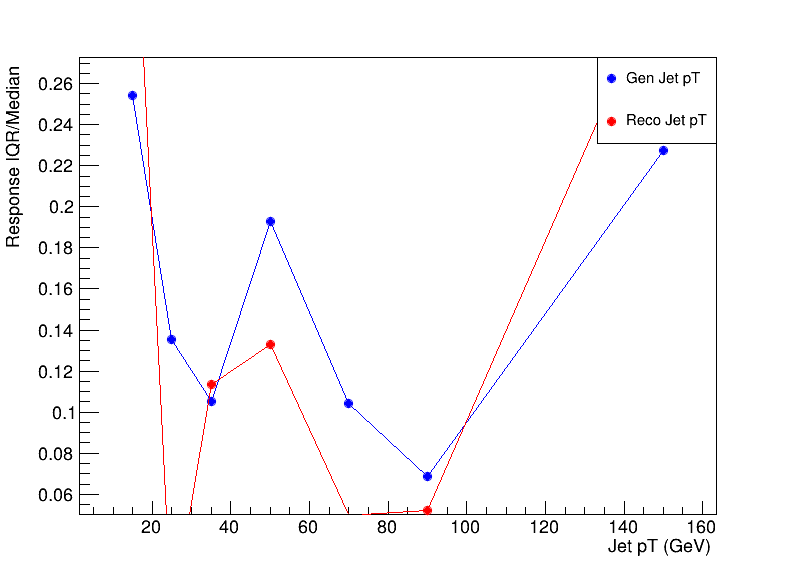

In [148]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
gen_ratio_iqr_median = []
reco_ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter gen_jet pT values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any gen_jet pT values in the bin
    if len(gen_jet_values_in_bin) == 0:
        # Append NaN values
        gen_ratio_iqr_median.append(np.nan)
    else:
        # Calculate IQR and median for gen_jet pT values
        gen_jet_iqr = np.percentile(gen_jet_values_in_bin, 75) - np.percentile(gen_jet_values_in_bin, 25)
        gen_jet_median = np.median(gen_jet_values_in_bin)
        gen_ratio_iqr_median_ratio = gen_jet_iqr / gen_jet_median
        gen_ratio_iqr_median.append(gen_ratio_iqr_median_ratio)

    # Filter reco_jet pT values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any reco_jet pT values in the bin
    if len(reco_jet_values_in_bin) == 0:
        # Append NaN values
        reco_ratio_iqr_median.append(np.nan)
    else:
        # Calculate IQR and median for reco_jet pT values
        reco_jet_iqr = np.percentile(reco_jet_values_in_bin, 75) - np.percentile(reco_jet_values_in_bin, 25)
        reco_jet_median = np.median(reco_jet_values_in_bin)
        reco_ratio_iqr_median_ratio = reco_jet_iqr / reco_jet_median
        reco_ratio_iqr_median.append(reco_ratio_iqr_median_ratio)

# Filter out NaN values for gen_jet pT
gen_x_vals_filtered = [x for x, y in zip(x_vals, gen_ratio_iqr_median) if not np.isnan(y)]
gen_ratio_iqr_median_filtered = [y for y in gen_ratio_iqr_median if not np.isnan(y)]

# Filter out NaN values for reco_jet pT
reco_x_vals_filtered = [x for x, y in zip(x_vals, reco_ratio_iqr_median) if not np.isnan(y)]
reco_ratio_iqr_median_filtered = [y for y in reco_ratio_iqr_median if not np.isnan(y)]

# Create TGraphs with filtered values
gr_gen_ratio = ROOT.TGraph(len(gen_x_vals_filtered), np.array(gen_x_vals_filtered), np.array(gen_ratio_iqr_median_filtered))
gr_reco_ratio = ROOT.TGraph(len(reco_x_vals_filtered), np.array(reco_x_vals_filtered), np.array(reco_ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_gen_ratio.SetTitle("")
gr_reco_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graphs with connecting lines
gr_gen_ratio.SetMarkerStyle(20)
gr_gen_ratio.SetMarkerColor(ROOT.kBlue)
gr_gen_ratio.SetLineColor(ROOT.kBlue)
gr_gen_ratio.GetXaxis().SetTitle("Jet pT (GeV)")
gr_gen_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_gen_ratio.Draw("APL")

gr_reco_ratio.SetMarkerStyle(20)
gr_reco_ratio.SetMarkerColor(ROOT.kRed)
gr_reco_ratio.SetLineColor(ROOT.kRed)
gr_reco_ratio.Draw("PL same")

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_gen_ratio, "Gen Jet pT", "p")
legend.AddEntry(gr_reco_ratio, "Reco Jet pT", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


In [ ]:
#Final plot of ratio of Reco_jet_pt/gen_jet_pt

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


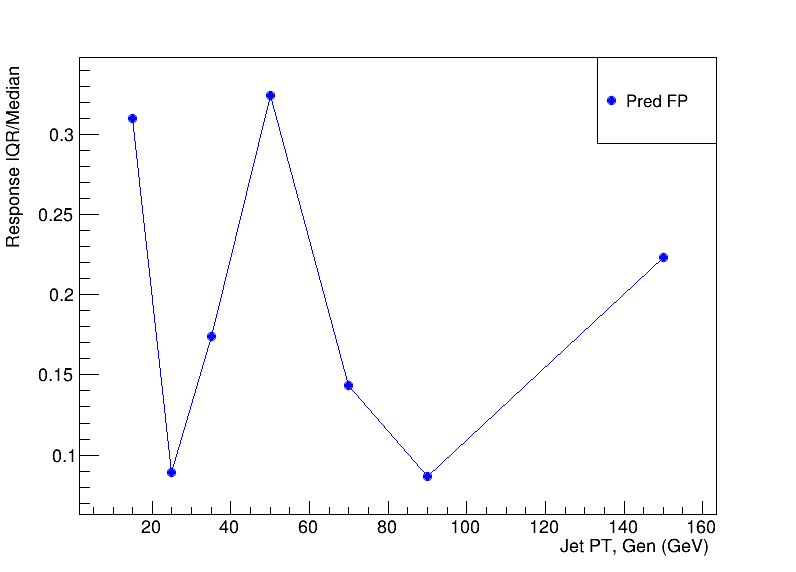

In [149]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter gen_jet pT values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Filter reco_jet pT values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any values in both gen_jet_pt and reco_jet_pt
    if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0:
        # Append NaN values
        ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median
    ratio_iqr_median.append(ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered = [x for x, y in zip(x_vals, ratio_iqr_median) if not np.isnan(y)]
ratio_iqr_median_filtered = [y for y in ratio_iqr_median if not np.isnan(y)]

# Create a TGraph with filtered values
gr_ratio = ROOT.TGraph(len(x_vals_filtered), np.array(x_vals_filtered), np.array(ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Jet PT, Gen (GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")

# Get the X and Y axes
xaxis = gr_ratio.GetXaxis()
yaxis = gr_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)


# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Pred FP", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


Warning in <TROOT::Append>: Replacing existing TH1: hist_5 (Potential memory leak).


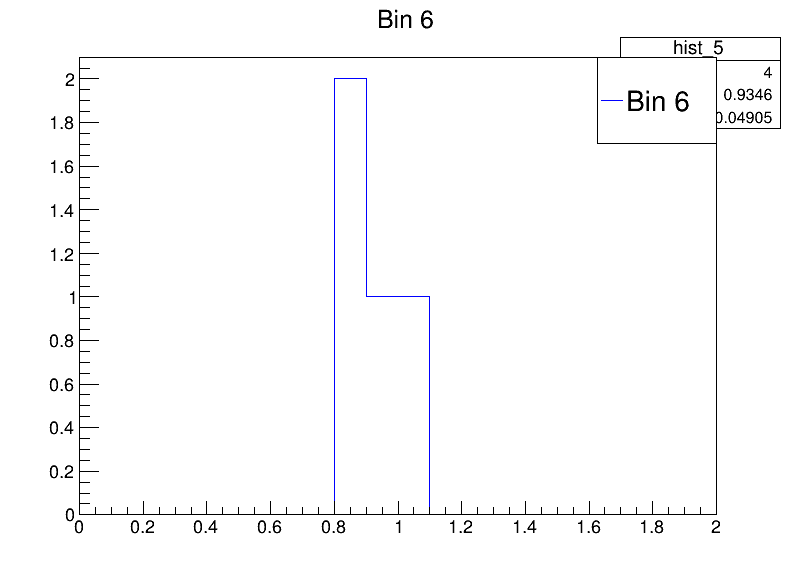

In [150]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Define the bin index for the first bin (index 0)
bin_index = 5

# Get the bin limits
lim_low = bins[bin_index]
lim_hi = bins[bin_index + 1]

# Filter gen_jet pT values within the bin
gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

# Filter reco_jet pT values within the bin
reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

# Check if there are any values in both gen_jet_pt and reco_jet_pt
if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0:
    print("No events in the bin.")
else:
    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
    ratio_median = np.median(ratio_values_in_bin)
    ratio_iqr_median_ratio = ratio_iqr / ratio_median

    # Create a canvas for the bin
    canvas = ROOT.TCanvas(f"canvas_{bin_index}", f"Response Distribution in Bin {bin_index + 1}", 800, 600)

    # Create histogram for the response distribution in the bin
    hist = ROOT.TH1F(f"hist_{bin_index}", f"  Bin {bin_index + 1}", 20, 0, 2)  # Adjust binning as needed
    for val in ratio_values_in_bin:
        hist.Fill(val)

    # Draw the histogram
    hist.SetLineColor(ROOT.kBlue)
    hist.Draw()

    # Add legend
    legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
    legend.AddEntry(hist, f"Bin {bin_index + 1}", "l")
    legend.Draw()

    # Show the canvas
    canvas.Draw()


In [151]:
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]

    # Filter gen_jet pT values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Filter reco_jet pT values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Calculate the number of events in the bin
    num_events_gen_jet = len(gen_jet_values_in_bin)
    num_events_reco_jet = len(reco_jet_values_in_bin)

    print(f"Bin {i+1}: Number of events (Gen Jet): {num_events_gen_jet}, Number of events (Reco Jet): {num_events_reco_jet}")


Bin 1: Number of events (Gen Jet): 16, Number of events (Reco Jet): 6
Bin 2: Number of events (Gen Jet): 6, Number of events (Reco Jet): 2
Bin 3: Number of events (Gen Jet): 7, Number of events (Reco Jet): 8
Bin 4: Number of events (Gen Jet): 13, Number of events (Reco Jet): 14
Bin 5: Number of events (Gen Jet): 6, Number of events (Reco Jet): 6
Bin 6: Number of events (Gen Jet): 8, Number of events (Reco Jet): 4
Bin 7: Number of events (Gen Jet): 6, Number of events (Reco Jet): 26


* After jet clustering use Je_Pt like you had for the MET and plot the IQR Response/Median vs Jet P_T[GeV]
* Do similar for the reco particle FP32 and for the INT8

#### jet with the gen particle 


In [ ]:
import fastjet as fj

# Assuming E, px, py, and pz are numpy arrays
particles = []
for ip in range(E.shape[0]):
    for ix in range(E.shape[1]):
        # Ensure that the momentum components and energy are converted to Python floats
        px_value = float(px[ip, ix])
        py_value = float(py[ip, ix])
        pz_value = float(pz[ip, ix])
        E_value = float(E[ip, ix])
        particles.append(fj.PseudoJet(px_value, py_value, pz_value, E_value))


print("First few elements of particles:")
for particle in particles[:5]:
    print(particle)

In [ ]:
# Perform jet clustering with FastJet
try:
    jet_R = 0.4  # Jet clustering radius
    jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R)  # Second parameter is pT_min
    clust_seq = fj.ClusterSequence(particles, jet_def)
    gen_jets = fj.sorted_by_pt(clust_seq.inclusive_jets())
    print("Jet clustering successful!")
except Exception as e:
    print(f"Error during jet clustering: {e}")


In [ ]:
# Print the  gen jets
for i, jet in enumerate(gen_jets):
    print(f"Jet {i+1}: ({jet.px()}, {jet.py()}, {jet.pz()}, {jet.e()})")

In [ ]:
# Print the total momentum of the gen jets
for i, jet in enumerate(gen_jets):
    total_momentum = np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2)
    print(f" gen_Jet {i+1}: Total Momentum: {total_momentum}")


#### jet with the reco particle for fp32


In [ ]:
px = preds_unpacked["pt"] * preds_unpacked["cos_phi"] * msk_pred_particles
py = preds_unpacked["pt"] * preds_unpacked["sin_phi"] * msk_pred_particles
pz = preds_unpacked["pt"] * np.sinh(preds_unpacked["eta"]) * msk_pred_particles
phi = np.arctan2(preds_unpacked["sin_phi"], preds_unpacked["cos_phi"]) * msk_pred_particles

px_np = px.detach().cpu().numpy()
py_np = py.detach().cpu().numpy()
pz_np = pz.detach().cpu().numpy()
phi_np = phi.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

pred_mom = np.sqrt(np.sum(px_np, axis=1)**2 + np.sum(py_np, axis=1)**2 + np.sum(pz_np, axis=1)**2)


In [ ]:
# four-vectors
E = np.sqrt(px_np**2 + py_np**2 + pz_np**2)
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("E Shape", E.shape)
print("px Shape", px.shape)
print("py Shape", py.shape)
print("pz Shape", pz.shape)

In [ ]:
import fastjet as fj

# Assuming E, px, py, and pz are numpy arrays
particles = []
for ip in range(E.shape[0]):
    for ix in range(E.shape[1]):
        # Ensure that the momentum components and energy are converted to Python floats
        px_value = float(px[ip, ix])
        py_value = float(py[ip, ix])
        pz_value = float(pz[ip, ix])
        E_value = float(E[ip, ix])
        particles.append(fj.PseudoJet(px_value, py_value, pz_value, E_value))


print("First few elements of particles:")
for particle in particles[:5]:
    print(particle)

In [ ]:
# Perform jet clustering with FastJet
try:
    jet_R = 0.4  # Jet clustering radius
    jet_def = fj.JetDefinition(fj.antikt_algorithm, jet_R)
    clust_seq = fj.ClusterSequence(particles, jet_def)
    reco_jets = fj.sorted_by_pt(clust_seq.inclusive_jets())
    print("Jet clustering successful!")
except Exception as e:
    print(f"Error during jet clustering: {e}")

In [ ]:
# Print the jets
for i, jet in enumerate(reco_jets):
    print(f" reco_Jet {i+1}: ({jet.px()}, {jet.py()}, {jet.pz()}, {jet.e()})")

In [ ]:
# Print the total momentum of the reco jets
for i, jet in enumerate(reco_jets):
    total_momentum = np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2)
    print(f" reco_Jet {i+1}: Total Momentum: {total_momentum}")


In [ ]:
## plotting of response ratio

In [ ]:
import ROOT
import numpy as np

bins = [10, 20, 30, 40, 60, 80, 100, 200]

x_vals_gen = []
x_vals_reco = []
ratio_iqr_median_gen = []
ratio_iqr_median_reco = []


In [ ]:
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals_gen.append(np.mean([lim_low, lim_hi]))
    x_vals_reco.append(np.mean([lim_low, lim_hi]))

    # Filtering total momentum values within the bin for gen_jets and reco_jets
    gen_values_in_bin = [np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2) for jet in gen_jets if
                         lim_low < np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2) <= lim_hi]
    reco_values_in_bin = [np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2) for jet in reco_jets if
                          lim_low < np.sqrt(jet.px()**2 + jet.py()**2 + jet.pz()**2) <= lim_hi]

    # making same shape
    min_length = min(len(reco_values_in_bin), len(gen_values_in_bin))
    reco_values_in_bin_resized = np.resize(reco_values_in_bin, min_length)
    gen_values_in_bin_resized = np.resize(gen_values_in_bin, min_length)

    #  ratio of reco/gen
    ratio_values_in_bin = reco_values_in_bin_resized / gen_values_in_bin_resized

    # IQR and median  for the ratio
    if len(ratio_values_in_bin) > 0:
        ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
        ratio_median = np.median(ratio_values_in_bin)
        ratio_iqr_median_ratio = ratio_iqr / ratio_median
        ratio_iqr_median_reco.append(ratio_iqr_median_ratio)
    else:
        ratio_iqr_median_reco.append(np.nan)


In [ ]:
# Create a TGraph for reco_jets
gr_ratio_reco = ROOT.TGraph(len(x_vals_reco), np.array(x_vals_reco), np.array(ratio_iqr_median_reco))

gr_ratio_reco.SetTitle("")

canvas_reco = ROOT.TCanvas("canvas_reco", "Ratio IQR/Median vs Momentum (Reco Jets)", 800, 600)
gr_ratio_reco.SetMarkerStyle(20)
gr_ratio_reco.SetMarkerColor(ROOT.kRed)
gr_ratio_reco.SetLineColor(ROOT.kRed)
gr_ratio_reco.GetXaxis().SetTitle("Jet_{Pt}(GeV)")
gr_ratio_reco.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio_reco.Draw("APL")

legend_reco = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend_reco.AddEntry(gr_ratio_reco, "Reco Jets", "p")
legend_reco.Draw()

canvas_reco.Draw()

-----

### another methods to create jets

In [ ]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

In [ ]:
print("true_momentum:",true_mom)

In [ ]:
print("pred_momentum:",pred_mom)

In [ ]:
true_mom.shape

In [ ]:
pred_mom.shape

In [ ]:
gen_bins = [ 10, 20, 30, 40, 60, 80, 100, 200]

x_vals = []
for ibin in range(len(gen_bins)-1):
    lim_low = gen_bins[ibin]
    lim_hi = gen_bins[ibin + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))
    
    msk_genmet = (true_mom > lim_low) & (true_mom <= lim_hi)
    
    

    

In [ ]:
msk_genmet

In [ ]:
# bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

x_vals = []
true_iqr_median_ratios = []
pred_iqr_median_ratios = []

In [ ]:
for ibin in range(len(bins) - 1):
    lim_low = bins[ibin]
    lim_hi = bins[ibin + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # values within the bin
    true_values_in_bin = true_mom[(true_mom > lim_low) & (true_mom <= lim_hi)]
    pred_values_in_bin = pred_mom[(pred_mom > lim_low) & (pred_mom <= lim_hi)]

    if len(true_values_in_bin) > 0:
        true_iqr = np.percentile(true_values_in_bin, 75) - np.percentile(true_values_in_bin, 25)
        true_median = np.median(true_values_in_bin)
        true_iqr_median_ratio = true_iqr / true_median
        true_iqr_median_ratios.append(true_iqr_median_ratio)
    else:
        true_iqr_median_ratios.append(np.nan)

    if len(pred_values_in_bin) > 0:
        pred_iqr = np.percentile(pred_values_in_bin, 75) - np.percentile(pred_values_in_bin, 25)
        pred_median = np.median(pred_values_in_bin)
        pred_iqr_median_ratio = pred_iqr / pred_median
        pred_iqr_median_ratios.append(pred_iqr_median_ratio)
    else:
        pred_iqr_median_ratios.append(np.nan)

In [ ]:
print("Length of x_vals:", len(x_vals))
print("Length of true_iqr_median_ratios:", len(true_iqr_median_ratios))
print("Length of pred_iqr_median_ratios:", len(pred_iqr_median_ratios))


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, true_iqr_median_ratios, label='True Momentum', color='blue', alpha=1)
plt.scatter(x_vals, pred_iqr_median_ratios, label='Predicted Momentum', color='red', alpha=1)
plt.xlabel('Momentum')
plt.ylabel('IQR/Median Ratio')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
import ROOT

In [ ]:
# Plot IQR/median ratio versus momentum
plt.figure(figsize=(10, 6))
plt.scatter(x_vals, true_iqr_median_ratios, label='True Momentum', color='blue', alpha=0.5)
plt.scatter(x_vals, pred_iqr_median_ratios, label='Predicted Momentum', color='red', alpha=0.5)
plt.plot(x_vals, true_iqr_median_ratios, linestyle='-', color='blue', alpha=0.7)
plt.plot(x_vals, pred_iqr_median_ratios, linestyle='-', color='red', alpha=0.7)
plt.xlabel('Momentum')
plt.ylabel('$IQR/Median Ratio$')
# plt.title('IQR/Median Ratio vs Momentum (Binned)')
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# Create a TGraph
gr_true = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(true_iqr_median_ratios))
gr_pred = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(pred_iqr_median_ratios))

# Set the titles to empty strings
gr_true.SetTitle("")
gr_pred.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "", 800, 600)

# Draw the graphs
gr_true.SetMarkerStyle(20)
gr_true.SetMarkerColor(ROOT.kBlue)
gr_true.SetLineColor(ROOT.kBlue)
gr_true.GetXaxis().SetTitle("P_{gen}(GeV)")
gr_true.GetYaxis().SetTitle("IQR/Median")
# Set number of divisions for the x and y axes
gr_true.GetXaxis().SetNdivisions(510)
gr_true.GetYaxis().SetNdivisions(510)
gr_true.Draw("AP")

gr_pred.SetMarkerStyle(20)
gr_pred.SetMarkerColor(ROOT.kRed)
gr_pred.SetLineColor(ROOT.kRed)
gr_pred.Draw("P")

# Create a TGraph for the line representing the true momentum
line_true = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(true_iqr_median_ratios))
line_true.SetLineColor(ROOT.kBlue)
line_true.SetLineWidth(2)
line_true.Draw("L")

# Create a TGraph for the line representing the predicted momentum
line_pred = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(pred_iqr_median_ratios))
line_pred.SetLineColor(ROOT.kRed)
line_pred.SetLineWidth(2)
line_pred.Draw("L")

# Add legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(gr_true, "True Momentum", "p")
legend.AddEntry(gr_pred, "Predicted Momentum", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


# Corrected one

In [106]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter true and predicted momentum values within the bin
    true_values_in_bin = true_mom[(true_mom > lim_low) & (true_mom <= lim_hi)]
    pred_values_in_bin = pred_mom[(pred_mom > lim_low) & (pred_mom <= lim_hi)]

    # Resize arrays to ensure they have the same shape
    min_length = min(len(pred_values_in_bin), len(true_values_in_bin))
    pred_values_in_bin_resized = np.resize(pred_values_in_bin, min_length)
    true_values_in_bin_resized = np.resize(true_values_in_bin, min_length)

    # Calculate ratio of pred/true
    ratio_values_in_bin = pred_values_in_bin_resized / true_values_in_bin_resized

    # Calculate IQR and median for the ratio
    if len(ratio_values_in_bin) > 0:
        ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
        ratio_median = np.median(ratio_values_in_bin)
        ratio_iqr_median_ratio = ratio_iqr / ratio_median
        ratio_iqr_median.append(ratio_iqr_median_ratio)
    else:
        ratio_iqr_median.append(np.nan)

# Create a TGraph
gr_ratio = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(ratio_iqr_median))

# Set the titles to empty strings
gr_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Momentum", 800, 600)

# Draw the graph with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("P_{gen}(GeV)")
gr_ratio.GetYaxis().SetTitle("Response IQR/Median")
gr_ratio.Draw("APL")


# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_ratio, "pred_fp32", "p")
legend.Draw()

# Show the canvas
canvas.Draw()


NameError: name 'pred_mom' is not defined

# quantization to INT8

In [152]:
model.eval()
model.qconfig = torch.ao.quantization.get_default_qconfig('onednn')
custom_module_config = {
        "float_to_observed_custom_module_class": {torch.nn.MultiheadAttention: QuantizeableMultiheadAttention},
        "observed_to_quantized_custom_module_class": {QuantizeableMultiheadAttention: QuantizedMultiheadAttention},
}

model_prepared = torch.ao.quantization.prepare(model, prepare_custom_config_dict=custom_module_config)

#calibrate on data
num_events_to_calibrate = 100
for ind in range(max_events_train,max_events_train+num_events_to_calibrate):
    _X = torch.unsqueeze(torch.tensor(ds_train[ind]["X"]).to(torch.float32), 0)
    _mask = _X[:, :, 0]!=0
    model_prepared(_X, _mask)

model_int8 = torch.ao.quantization.convert(model_prepared,convert_custom_config_dict=custom_module_config,)

/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:1207: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(


In [153]:
model_int8.quant

QuantizeFeaturesStub(
  (quants): ModuleList(
    (0): Quantize(scale=tensor([0.0078]), zero_point=tensor([0]), dtype=torch.quint8)
    (1): Quantize(scale=tensor([0.0396]), zero_point=tensor([138]), dtype=torch.quint8)
    (2): Quantize(scale=tensor([0.0342]), zero_point=tensor([129]), dtype=torch.quint8)
    (3): Quantize(scale=tensor([0.0078]), zero_point=tensor([127]), dtype=torch.quint8)
    (4): Quantize(scale=tensor([0.0078]), zero_point=tensor([128]), dtype=torch.quint8)
    (5): Quantize(scale=tensor([0.0339]), zero_point=tensor([117]), dtype=torch.quint8)
    (6): Quantize(scale=tensor([49.7997]), zero_point=tensor([62]), dtype=torch.quint8)
    (7): Quantize(scale=tensor([22.5108]), zero_point=tensor([128]), dtype=torch.quint8)
    (8): Quantize(scale=tensor([30.9407]), zero_point=tensor([130]), dtype=torch.quint8)
    (9): Quantize(scale=tensor([0.0122]), zero_point=tensor([0]), dtype=torch.quint8)
    (10): Quantize(scale=tensor([3.2249]), zero_point=tensor([0]), dtype=tor

In [154]:
mask_quantized = torch.quantize_per_tensor((X_features_padded[:, :, 0]!=0).to(torch.float32), 1, 0, torch.quint8)
preds = model_int8(X_features_padded, mask_quantized)
preds = preds[0].detach(), preds[1].detach()
preds_unpacked_int8 = unpack_predictions(preds)

## Physics performance


In [155]:
loss_int8 = mlpf_loss(targets_unpacked, preds_unpacked_int8, mask)

Text(0, 0.5, 'Final total loss')

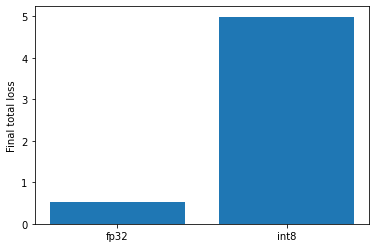

In [156]:
plt.bar(range(2), [loss["Total"].detach().numpy(), loss_int8["Total"].detach().numpy()])
plt.xticks(range(2), ["fp32", "int8"])
plt.ylabel("Final total loss")

In [157]:
pt_pred_int8 = preds_unpacked_int8["pt"][msk_true_particles].numpy()
eta_pred_int8 = preds_unpacked_int8["eta"][msk_true_particles].numpy()
sphi_pred_int8 = preds_unpacked_int8["sin_phi"][msk_true_particles].numpy()
cphi_pred_int8 = preds_unpacked_int8["cos_phi"][msk_true_particles].numpy()
energy_pred_int8 = preds_unpacked_int8["energy"][msk_true_particles].numpy()

px = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pred_met_int8 = torch.sqrt(torch.sum(px, axis=-2) ** 2 + torch.sum(py, axis=-2) ** 2)

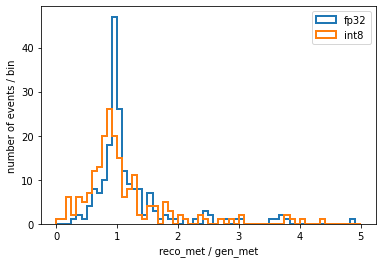

In [158]:
plt.hist(pred_met/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="fp32");
plt.hist(pred_met_int8/true_met, bins=np.linspace(0,5,61), histtype="step", lw=2, label="int8");
plt.xlabel("reco_met / gen_met")
plt.ylabel("number of events / bin")
plt.legend(loc="best")

In [159]:
# Defining the 3-momentum for the quantized particles.


In [160]:
px_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["cos_phi"] * msk_true_particles
py_int8 = preds_unpacked_int8["pt"] * preds_unpacked_int8["sin_phi"] * msk_true_particles
pz_int8 = preds_unpacked_int8["pt"] * np.sinh(preds_unpacked_int8["eta"]) * msk_true_particles
phi_int8 = np.arctan2(preds_unpacked_int8["sin_phi"], preds_unpacked_int8["cos_phi"]) * msk_true_particles

px_np_int8 = px_int8.detach().cpu().numpy()
py_np_int8 = py_int8.detach().cpu().numpy()
pz_np_int8 = pz_int8.detach().cpu().numpy()
phi_np_int8 = phi_int8.detach().cpu().numpy()

# print("px_np", px_np)
# print("py_np", py_np)
# print("pz_np", pz_np)
# print("phi_np", phi_np)

quantized_mom = np.sqrt(np.sum(px_np_int8, axis=1)**2 + np.sum(py_np_int8, axis=1)**2 + np.sum(pz_np_int8, axis=1)**2)
int8_E_np = np.sqrt(px_np_int8**2 + py_np_int8**2 + pz_np_int8**2)


In [161]:
# four-vectors
# px_py_pz_E = np.column_stack((px_np, py_np, pz_np, E)) 
print("int8_E Shape", int8_E_np.shape)
print("px Shape", px_np_int8.shape)
print("py Shape", py_np_int8.shape)
print("pz Shape", pz_np_int8.shape)


int8_E Shape (16, 200)
px Shape (16, 200)
py Shape (16, 200)
pz Shape (16, 200)


In [162]:

INT8_Jets_particles = []   # TODO:Change this to reco_jets
for ip in range(int8_E_np.shape[0]):
    for ix in range(int8_E_np.shape[1]):
        px_value = float(px_np_int8[ip, ix])
        py_value = float(py_np_int8[ip, ix])
        pz_value = float(pz_np_int8[ip, ix])
        E_value = float(int8_E_np[ip, ix])
        particle = fj.PseudoJet(px_value, py_value, pz_value, E_value)
        INT8_Jets_particles.append(particle)


In [163]:
INT8_Jets_particles

[<fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a8151b70> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a8151330> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805ab780> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805aba20> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805ab0c0> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805ab840> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805ab240> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2805ab060> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at 0x7fe2a80e7090> >,
 <fastjet._swig.PseudoJet; proxy of <Swig Object of type 'fastjet::PseudoJet *' at

In [164]:
# # jets clustering
# jetdef = fj.JetDefinition(fj.kt_algorithm, 0.4)  # Define jet definition
# jet_ptcut = 20  # Minimum jet pT
# cluster = fj.ClusterSequence(INT8_Jets, jetdef)
# INT8_reco_jets = cluster.inclusive_jets(jet_ptcut)


In [165]:
from concurrent.futures import ThreadPoolExecutor

num_threads = 2 

def cluster_jets(particles):
    jetdef = fj.JetDefinition(fj.kt_algorithm, 0.4)
#     jet_ptcut = 20
    
    cluster = fj.ClusterSequence(INT8_Jets_particles, jetdef)
    jets = cluster.inclusive_jets()
    
    return jets

chunks = [particles[i::num_threads] for i in range(num_threads)]

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(cluster_jets, chunk) for chunk in chunks]

INT8_reco_jets = []
for future in futures:
    INT8_reco_jets.extend(future.result())


In [166]:
for i, jet in enumerate(INT8_reco_jets):
    print("Jet", i+1, ":", jet.pt(), jet.eta(), jet.phi(), jet.e())

Jet 1 : 175.38168559739486 1.5189522648230134 0.2712425254035936 421.7320156535134
Jet 2 : 170.42794453244008 0.7161476924038105 1.641824540882641 218.86877262964845
Jet 3 : 155.6666470599995 1.1169396250125903 2.498318453597667 266.94300524145365
Jet 4 : 149.7050425319709 1.3265089872455225 0.9300096062761378 303.337260203436
Jet 5 : 136.06674212239108 0.17654577570089658 4.184812768981503 142.3736191317439
Jet 6 : 131.66551401244774 1.2627924970817739 5.583203733718152 252.92109870538116
Jet 7 : 129.79782044787612 0.49616006536193463 2.9709766019842374 148.97480954229832
Jet 8 : 103.53830344217904 1.2604547637499028 4.634915748640614 197.92510555684566
Jet 9 : 92.14723026950044 1.0389957330573867 4.21871371163579 148.65662144683301
Jet 10 : 87.1605771737606 1.3012013905262867 1.5338488999794495 172.47226512432098
Jet 11 : 86.2656326488587 1.1369520139523666 0.06840317633593854 148.97730095684528
Jet 12 : 84.8307960865447 1.723978891967307 1.3318604708920017 245.95693765580654
Jet 13 

Jet 146 : 40.692387727088935 2.48541703761816 2.983075915941491 246.10130022466183
Jet 147 : 37.471162587884834 2.0882174715342283 2.314862312889604 153.59847033023834
Jet 148 : 35.33077518366219 2.6294172957667348 1.508926161702586 246.36686623096466
Jet 149 : 35.12603519666596 0.5573524051893971 3.7872646805773185 41.11799411289394
Jet 150 : 32.33874966208273 1.2183344073246867 3.4413060050986357 59.80528609454632
Jet 151 : 32.19403505415288 0.17654116811686407 2.5096587359651945 33.01929024606943
Jet 152 : 31.475800896721175 0.14862115265895876 1.652151396991755 32.39059119671583
Jet 153 : 31.365601813838687 2.339501536372488 4.590808733822291 164.35101717710495
Jet 154 : 30.43353737948531 1.9421565619331305 5.594060044185124 108.40801008045673
Jet 155 : 29.3219197295056 1.4547581095675641 3.8207509507644613 66.2895258772187
Jet 156 : 28.55615223306646 -0.703295721619098 3.622534915776032 36.32677436992526
Jet 157 : 26.714382291249944 1.7896770619341442 4.733402353073718 82.31800563

In [167]:
print("Number of Jets:", len(INT8_reco_jets))


INT8_jet_pt = [jet.pt() for jet in INT8_reco_jets]

Number of Jets: 228


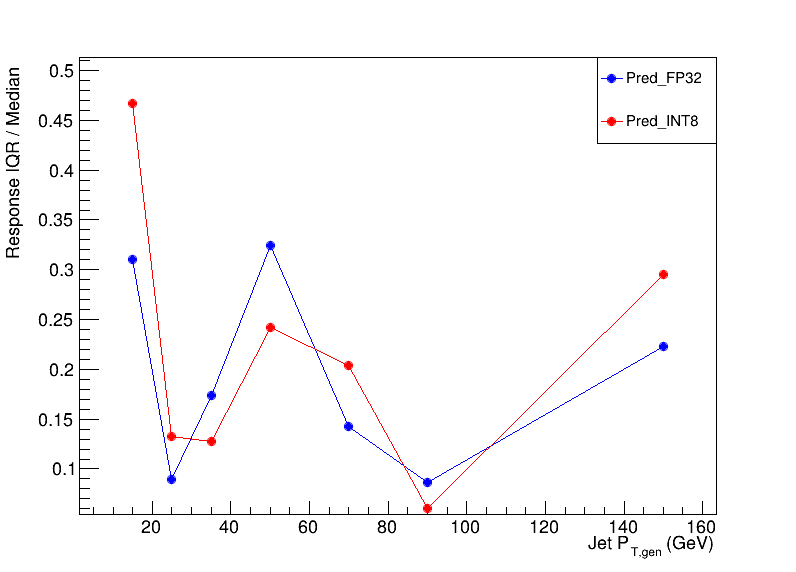

In [168]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
reco_ratio_iqr_median = []
int8_ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter gen_jet_pt values within the bin
    gen_jet_values_in_bin = [pt for pt in gen_jet_pt if lim_low < pt <= lim_hi]

    # Filter reco_jet_pt values within the bin
    reco_jet_values_in_bin = [pt for pt in reco_jet_pt if lim_low < pt <= lim_hi]

    # Filter INT8_jet_pt values within the bin
    INT8_jet_values_in_bin = [pt for pt in INT8_jet_pt if lim_low < pt <= lim_hi]

    # Check if there are any values in both gen_jet_pt and reco_jet_pt
    if len(gen_jet_values_in_bin) == 0 or len(reco_jet_values_in_bin) == 0 or len(INT8_jet_values_in_bin) == 0:
        # Append NaN values
        reco_ratio_iqr_median.append(np.nan)
        int8_ratio_iqr_median.append(np.nan)
        continue

    # Calculate IQR and median for reco_jet_pt / gen_jet_pt values
    reco_ratio_values_in_bin = [reco / gen for reco, gen in zip(reco_jet_values_in_bin, gen_jet_values_in_bin)]
    reco_ratio_iqr = np.percentile(reco_ratio_values_in_bin, 75) - np.percentile(reco_ratio_values_in_bin, 25)
    reco_ratio_median = np.median(reco_ratio_values_in_bin)
    reco_ratio_iqr_median_ratio = reco_ratio_iqr / reco_ratio_median
    reco_ratio_iqr_median.append(reco_ratio_iqr_median_ratio)

    # Calculate IQR and median for INT8_jet_pt / gen_jet_pt values
    int8_ratio_values_in_bin = [int8 / gen for int8, gen in zip(INT8_jet_values_in_bin, gen_jet_values_in_bin)]
    int8_ratio_iqr = np.percentile(int8_ratio_values_in_bin, 75) - np.percentile(int8_ratio_values_in_bin, 25)
    int8_ratio_median = np.median(int8_ratio_values_in_bin)
    int8_ratio_iqr_median_ratio = int8_ratio_iqr / int8_ratio_median
    int8_ratio_iqr_median.append(int8_ratio_iqr_median_ratio)

# Filter out NaN values
x_vals_filtered_reco = [x for x, y in zip(x_vals, reco_ratio_iqr_median) if not np.isnan(y)]
reco_ratio_iqr_median_filtered = [y for y in reco_ratio_iqr_median if not np.isnan(y)]

x_vals_filtered_int8 = [x for x, y in zip(x_vals, int8_ratio_iqr_median) if not np.isnan(y)]
int8_ratio_iqr_median_filtered = [y for y in int8_ratio_iqr_median if not np.isnan(y)]

# Create TGraphs with filtered values
gr_reco_ratio = ROOT.TGraph(len(x_vals_filtered_reco), np.array(x_vals_filtered_reco), np.array(reco_ratio_iqr_median_filtered))
gr_int8_ratio = ROOT.TGraph(len(x_vals_filtered_int8), np.array(x_vals_filtered_int8), np.array(int8_ratio_iqr_median_filtered))

# Set the titles to empty strings
gr_reco_ratio.SetTitle("")
gr_int8_ratio.SetTitle("")

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Jet pT", 800, 600)

# Draw the first graph (Reco_jet_pt/gen_jet_pt)
gr_reco_ratio.SetMarkerStyle(20)
gr_reco_ratio.SetMarkerColor(ROOT.kBlue)
gr_reco_ratio.SetLineColor(ROOT.kBlue)
gr_reco_ratio.GetXaxis().SetTitle("Jet P_{T,gen} (GeV)")
gr_reco_ratio.GetYaxis().SetTitle("Response IQR / Median")
gr_reco_ratio.Draw("APL")

# Draw the second graph (INT8_jet_pt/gen_jet_pt) on the same canvas
gr_int8_ratio.SetMarkerStyle(20)
gr_int8_ratio.SetMarkerColor(ROOT.kRed)
gr_int8_ratio.SetLineColor(ROOT.kRed)
gr_int8_ratio.Draw("PL same")

# Get the X and Y axes
xaxis = gr_reco_ratio.GetXaxis()
yaxis = gr_reco_ratio.GetYaxis()

# Set tick length for all four axes
xaxis.SetTickLength(0.03)
yaxis.SetTickLength(0.03)

# Set y-axis range to show both plots
min_y = min(min(reco_ratio_iqr_median_filtered), min(int8_ratio_iqr_median_filtered))
max_y = max(max(reco_ratio_iqr_median_filtered), max(int8_ratio_iqr_median_filtered))
yaxis.SetRangeUser(min_y * 0.9, max_y * 1.1)

# Add legend
legend = ROOT.TLegend(0.75, 0.75, 0.9, 0.9)
legend.AddEntry(gr_reco_ratio, "Pred_FP32", "lp")
legend.AddEntry(gr_int8_ratio, "Pred_INT8", "lp")
legend.Draw()

# Show the canvas
canvas.Draw()


In [ ]:
quantized_mom

In [ ]:
import ROOT
import numpy as np

# Define bins
bins = [10, 20, 30, 40, 60, 80, 100, 200]

# Initialize lists to store values
x_vals = []
ratio_iqr_median = []
quantized_ratio_iqr_median = []

# Iterate over bins
for i in range(len(bins) - 1):
    lim_low = bins[i]
    lim_hi = bins[i + 1]
    x_vals.append(np.mean([lim_low, lim_hi]))

    # Filter true and predicted momentum values within the bin
    true_values_in_bin = true_mom[(true_mom > lim_low) & (true_mom <= lim_hi)]
    pred_values_in_bin = pred_mom[(pred_mom > lim_low) & (pred_mom <= lim_hi)]
    quantized_values_in_bin = quantized_mom[(quantized_mom > lim_low) & (quantized_mom <= lim_hi)]

    # Resize arrays to ensure they have the same shape
    min_length = min(len(pred_values_in_bin), len(true_values_in_bin), len(quantized_values_in_bin))
    pred_values_in_bin_resized = np.resize(pred_values_in_bin, min_length)
    true_values_in_bin_resized = np.resize(true_values_in_bin, min_length)
    quantized_values_in_bin_resized = np.resize(quantized_values_in_bin, min_length)

    # Calculate ratios
    ratio_values_in_bin = pred_values_in_bin_resized / true_values_in_bin_resized
    quantized_ratio_values_in_bin = quantized_values_in_bin_resized / true_values_in_bin_resized

    # Calculate IQR and median for the ratios
    if len(ratio_values_in_bin) > 0:
        ratio_iqr = np.percentile(ratio_values_in_bin, 75) - np.percentile(ratio_values_in_bin, 25)
        ratio_median = np.median(ratio_values_in_bin)
        ratio_iqr_median_ratio = ratio_iqr / ratio_median
        ratio_iqr_median.append(ratio_iqr_median_ratio)
    else:
        ratio_iqr_median.append(np.nan)

    if len(quantized_ratio_values_in_bin) > 0:
        quantized_ratio_iqr = np.percentile(quantized_ratio_values_in_bin, 75) - np.percentile(quantized_ratio_values_in_bin, 25)
        quantized_ratio_median = np.median(quantized_ratio_values_in_bin)
        quantized_ratio_iqr_median_ratio = quantized_ratio_iqr / quantized_ratio_median
        quantized_ratio_iqr_median.append(quantized_ratio_iqr_median_ratio)
    else:
        quantized_ratio_iqr_median.append(np.nan)

# Create TGraphs
gr_ratio = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(ratio_iqr_median))
gr_quantized_ratio = ROOT.TGraph(len(x_vals), np.array(x_vals), np.array(quantized_ratio_iqr_median))

# Create a canvas
canvas = ROOT.TCanvas("canvas", "Ratio IQR/Median vs Momentum", 800, 600)

# Draw the graphs with connecting lines
gr_ratio.SetMarkerStyle(20)
gr_ratio.SetMarkerColor(ROOT.kBlue)
gr_ratio.SetLineColor(ROOT.kBlue)
gr_ratio.GetXaxis().SetTitle("Momentum")
gr_ratio.GetYaxis().SetTitle("Ratio IQR/Median")
gr_ratio.Draw("APL")

gr_quantized_ratio.SetMarkerStyle(20)
gr_quantized_ratio.SetMarkerColor(ROOT.kRed)
gr_quantized_ratio.SetLineColor(ROOT.kRed)
gr_quantized_ratio.Draw("PL")

# Add legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(gr_ratio, "Ratio IQR/Median", "lp")
legend.AddEntry(gr_quantized_ratio, "Quantized Ratio IQR/Median", "lp")
legend.Draw()

# Show the canvas
canvas.Draw()


## Jets

# With larger number of statistics

In [ ]:
import awkward
import fastjet
import vector